# Week 4 - Illumination Normalization using Temporal Blending

**Goal:** Demonstrate and evaluate a simple illumination normalization technique using frame-to-frame temporal blending. This aims to smooth out rapid lighting changes or normalize exposure slightly, providing more consistent input for subsequent image processing tasks like object classification.

**Method:**
- We use an `IlluminationNormalizer` class that maintains a running "reference" frame.
- Each new incoming frame is blended with this reference frame using a weighted average:
  `blended_frame = alpha * current_frame + (1 - alpha) * old_reference_frame`
- The `blended_frame` then becomes the new reference frame for the next iteration.
- The `alpha` parameter controls the speed of adaptation:
    - High `alpha` (e.g., 0.8-0.95): Faster adaptation, current frame has more influence.
    - Low `alpha` (e.g., 0.05-0.2): Slower adaptation, reference frame has more influence, leading to more smoothing of rapid changes.

**Evaluation:**
- Simulate varying lighting conditions.
- Visualize raw, reference, and normalized frames.
- Plot mean intensity of a Region of Interest (ROI) over time for raw vs. normalized frames to show the smoothing effect.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# --- Add project root to Python path for module imports ---
# This assumes the notebook is in 'object_sorter_model/notebooks/'
# and the package 'object_sorter_model' is one level up.
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')) # In a notebook, __file__ might not work as expected
# A more robust way if running from 'notebooks' directory:
CURRENT_DIR = os.getcwd()
if os.path.basename(CURRENT_DIR) == 'notebooks':
    PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))
else: # Fallback if running from project root or elsewhere, adjust as needed
    PROJECT_ROOT = CURRENT_DIR # Or specify absolute path

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    print(f"Added to sys.path: {PROJECT_ROOT}")

try:
    from object_sorter_model.preprocessing.temporal_blending import IlluminationNormalizer
except ImportError as e:
    print(f"Error importing IlluminationNormalizer: {e}")
    print("Make sure the project structure is correct and you are running from a suitable directory (e.g., 'notebooks' or project root).")
    print(f"Current sys.path: {sys.path}")
    raise

# --- Configuration for the Notebook ---
OUTPUT_DIR_NOTEBOOK = "output_week4_notebook_illum_norm"
os.makedirs(OUTPUT_DIR_NOTEBOOK, exist_ok=True)

# Simulation parameters
NUM_FRAMES_SIM = 30
BASE_BRIGHTNESS = 128
BRIGHTNESS_VARIATION_AMPLITUDE = 50 # How much brightness will fluctuate
VARIATION_FREQUENCY = 0.2 # How fast brightness changes (cycles per frame)
ROI_FOR_ANALYSIS = (50, 50, 100, 100) # (x, y, w, h) for mean intensity calculation

# Normalizer parameters to test
ALPHA_FAST_ADAPT = 0.8
ALPHA_SLOW_ADAPT = 0.1

print("Setup complete. IlluminationNormalizer imported.")

Added to sys.path: /home/novillus/Documents/Development/Python-projects/computer-vision-course-3-months/object_sorter_model
Setup complete. IlluminationNormalizer imported.


## 1. Helper Functions for Simulation and Visualization

In [2]:
def generate_simulated_frames(num_frames, height, width, 
                              base_brightness, variation_amplitude, variation_freq):
    """Generates a sequence of frames with sinusoidally varying brightness."""
    frames = []
    # Create a base pattern for the image (e.g., a gradient or a simple shape)
    base_pattern = np.zeros((height, width, 3), dtype=np.float32)
    for r in range(height):
        base_pattern[r, :, 0] = r / height * 200 # Blue gradient
    cv2.circle(base_pattern, (width // 2, height // 2), min(height,width)//4, (0, 180, 0), -1) # Green circle
    base_pattern = np.clip(base_pattern, 0, 255)


    for i in range(num_frames):
        # Sinusoidal brightness variation
        brightness_factor = (variation_amplitude * np.sin(2 * np.pi * variation_freq * i) + base_brightness) / 255.0
        brightness_factor = np.clip(brightness_factor, 0.1, 2.0) # Ensure it doesn't go too dark/bright

        frame_float = base_pattern * brightness_factor
        frame_uint8 = np.clip(frame_float, 0, 255).astype(np.uint8)
        frames.append(frame_uint8)
    return frames

def display_frame_comparison(raw_frame, ref_frame, norm_frame, frame_num, save_path=None):
    """Displays raw, reference, and normalized frames side-by-side."""
    if raw_frame is None or ref_frame is None or norm_frame is None: return

    h, w = raw_frame.shape[:2]
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    raw_display = cv2.putText(raw_frame.copy(), "Raw", (10, h-10), font, 0.5, (0,0,255), 1, cv2.LINE_AA)
    ref_display = cv2.putText(ref_frame.copy(), "Reference", (10, h-10), font, 0.5, (0,255,0), 1, cv2.LINE_AA)
    norm_display = cv2.putText(norm_frame.copy(), "Normalized", (10, h-10), font, 0.5, (255,0,0), 1, cv2.LINE_AA)
    
    combined_img = np.hstack((raw_display, ref_display, norm_display))
    
    plt.figure(figsize=(12, 4))
    plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_num}: Raw | Reference | Normalized")
    plt.axis('off')
    if save_path:
        cv2.imwrite(save_path, combined_img)
        # print(f"Saved: {save_path}")
    plt.show()
    
def get_roi_mean_intensity(frame, roi_xywh):
    """Calculates mean intensity of a grayscale ROI."""
    if frame is None: return 0
    x, y, w, h = roi_xywh
    roi_area = frame[y:y+h, x:x+w]
    if roi_area.ndim == 3:
        roi_area = cv2.cvtColor(roi_area, cv2.COLOR_BGR2GRAY)
    return np.mean(roi_area)

print("Helper functions for simulation and display defined.")

Helper functions for simulation and display defined.


## 2. Simulate Frame Sequence with Varying Illumination
We'll create a sequence of synthetic frames where the overall brightness changes over time to simulate fluctuating lighting conditions.

Generated 30 simulated frames.


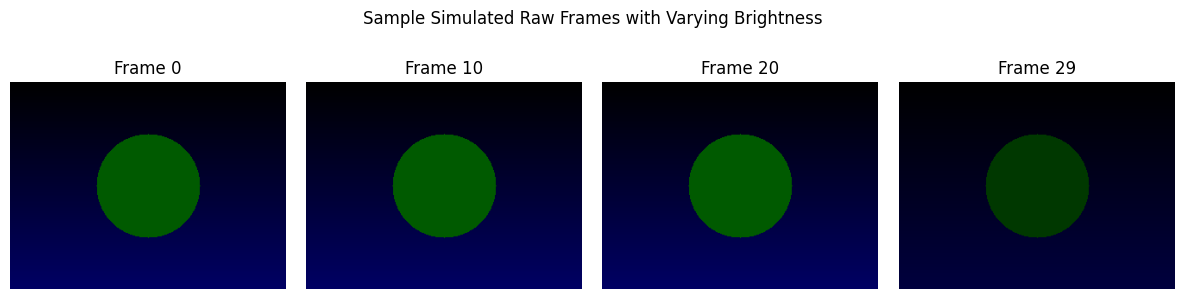

In [3]:
sim_frame_height, sim_frame_width = 240, 320
simulated_frames = generate_simulated_frames(
    NUM_FRAMES_SIM, sim_frame_height, sim_frame_width,
    BASE_BRIGHTNESS, BRIGHTNESS_VARIATION_AMPLITUDE, VARIATION_FREQUENCY
)

# Display a few sample simulated frames
print(f"Generated {len(simulated_frames)} simulated frames.")
sample_indices_to_show = [0, NUM_FRAMES_SIM // 3, 2 * NUM_FRAMES_SIM // 3, NUM_FRAMES_SIM -1]
fig, axs = plt.subplots(1, len(sample_indices_to_show), figsize=(12,3))
plt.suptitle("Sample Simulated Raw Frames with Varying Brightness")
for i, frame_idx in enumerate(sample_indices_to_show):
    axs[i].imshow(cv2.cvtColor(simulated_frames[frame_idx], cv2.COLOR_BGR2RGB))
    axs[i].set_title(f"Frame {frame_idx}")
    axs[i].axis('off')
plt.tight_layout(rect=[0,0,1,0.9])
plt.show()

## 3. Apply Illumination Normalization

We will process the simulated frame sequence using the `IlluminationNormalizer` with two different `alpha` values:
- High `alpha` (fast adaptation)
- Low `alpha` (slow adaptation, more smoothing)

We'll collect mean intensities from a defined ROI for both raw and normalized frames.


Processing with Alpha = 0.80
  Frame 1/30 processed.


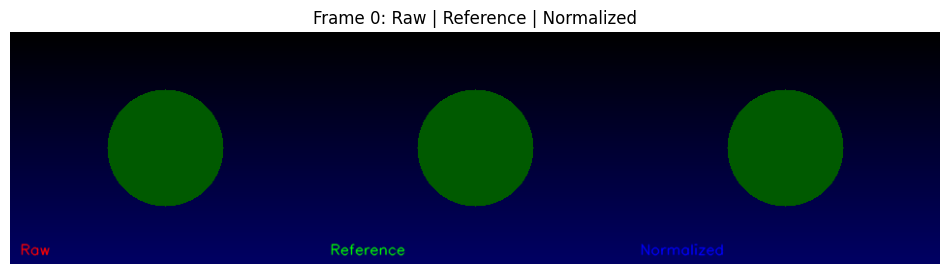

  Frame 7/30 processed.


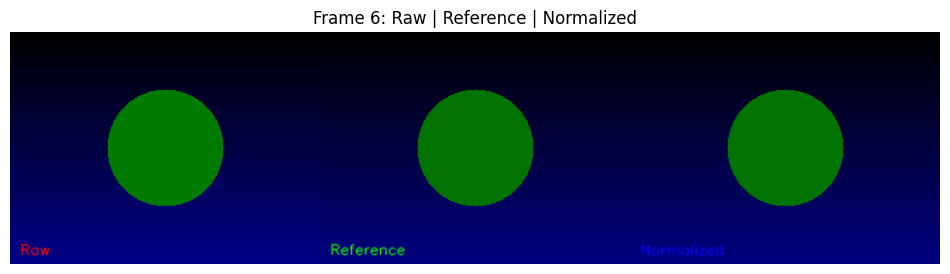

  Frame 14/30 processed.


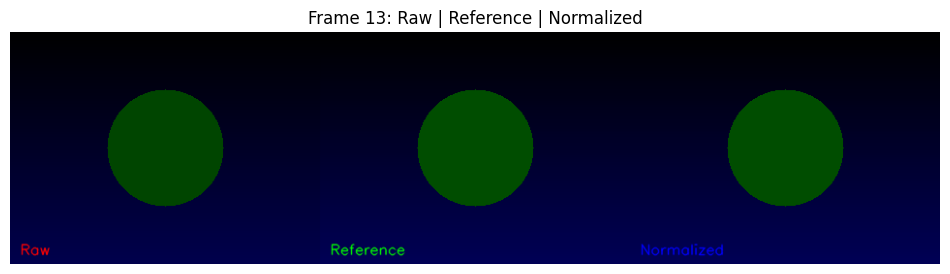

  Frame 21/30 processed.


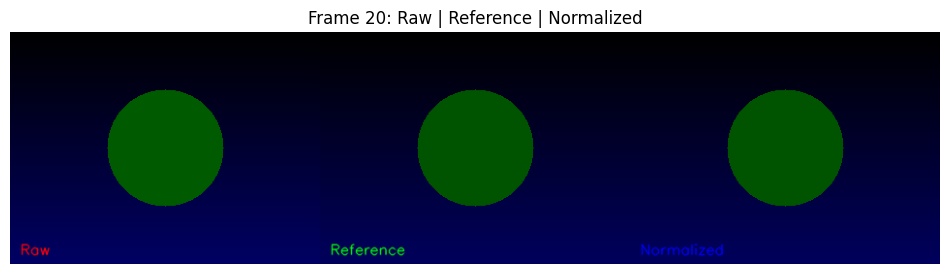

  Frame 28/30 processed.


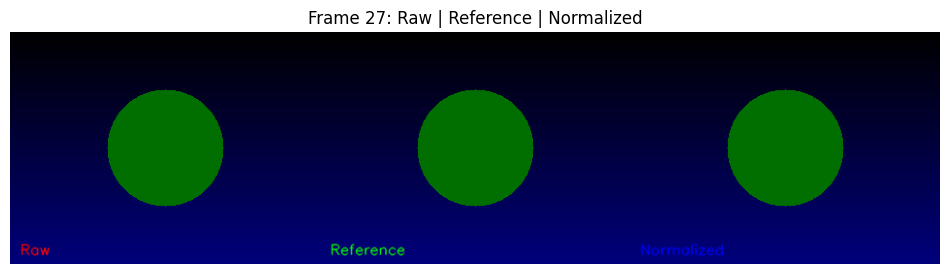

  Frame 30/30 processed.


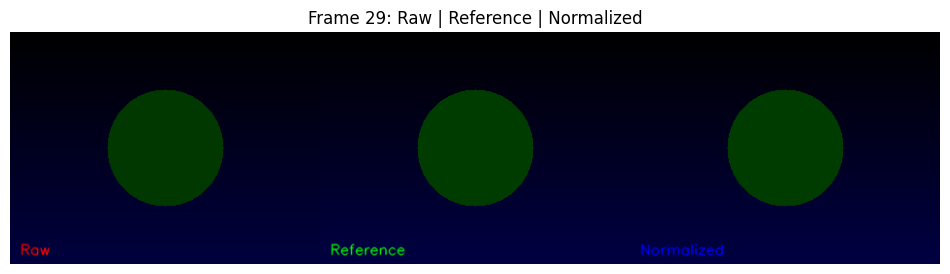


Processing with Alpha = 0.10
  Frame 1/30 processed.


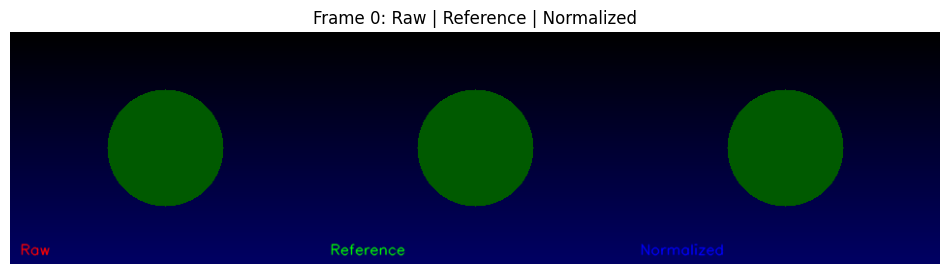

  Frame 7/30 processed.


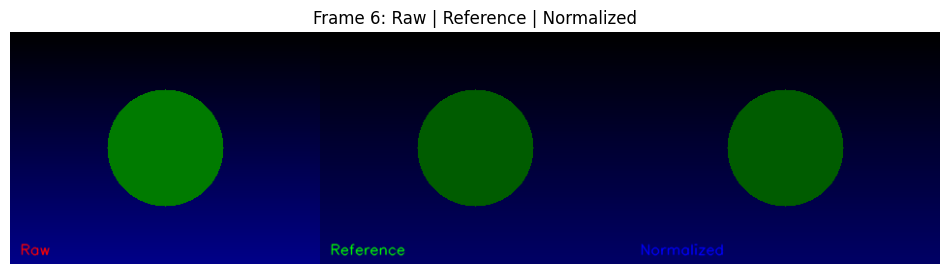

  Frame 14/30 processed.


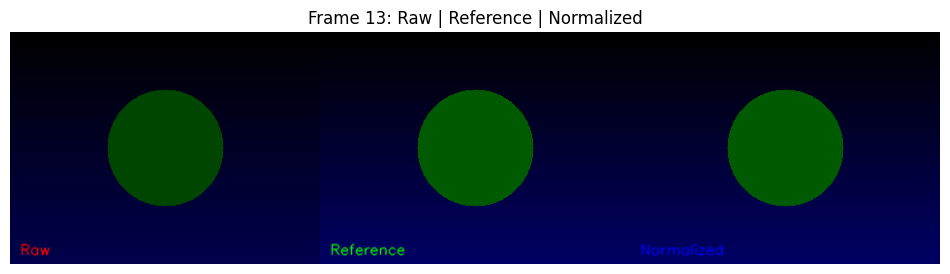

  Frame 21/30 processed.


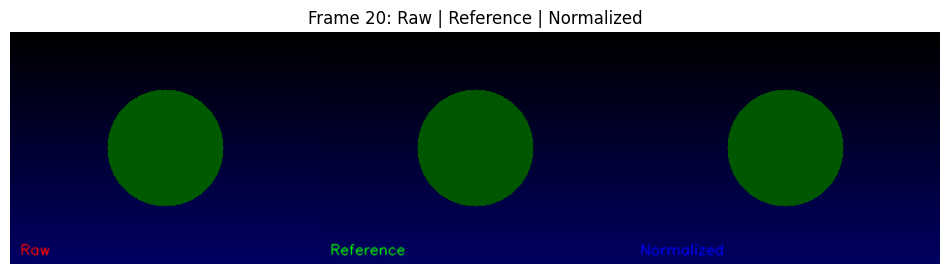

  Frame 28/30 processed.


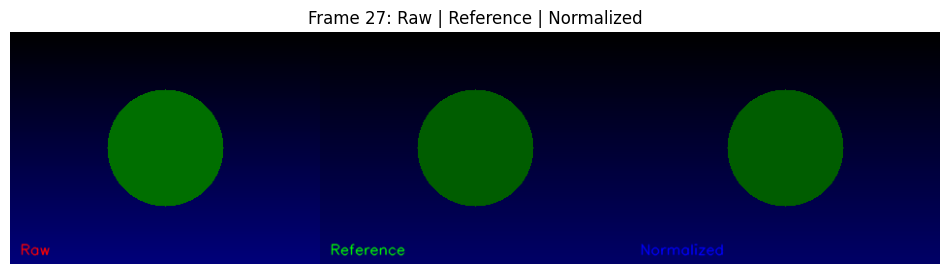

  Frame 30/30 processed.


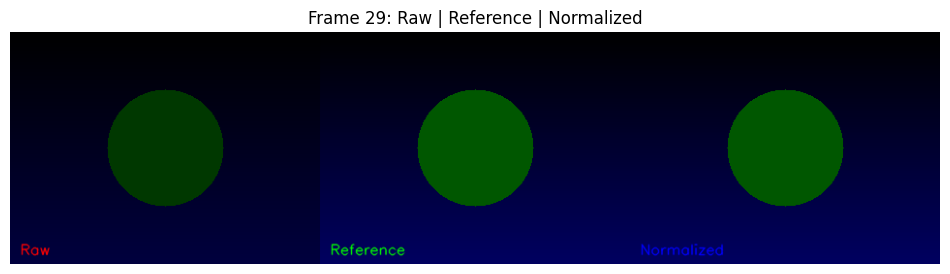

In [4]:
def process_sequence(frames, normalizer_alpha, roi_xywh, display_interval=5, save_prefix=""):
    normalizer = IlluminationNormalizer(alpha=normalizer_alpha, frame_shape=frames[0].shape[:3])
    
    raw_means = []
    norm_means = []
    ref_means = [] # For interest, what's the reference intensity

    print(f"\nProcessing with Alpha = {normalizer_alpha:.2f}")
    for i, raw_frame in enumerate(frames):
        normalized_frame, reference_frame = normalizer.normalize_frame(raw_frame)
        
        raw_means.append(get_roi_mean_intensity(raw_frame, roi_xywh))
        norm_means.append(get_roi_mean_intensity(normalized_frame, roi_xywh))
        ref_means.append(get_roi_mean_intensity(reference_frame, roi_xywh))

        if (i + 1) % display_interval == 0 or i == 0 or i == len(frames) - 1:
            print(f"  Frame {i+1}/{len(frames)} processed.")
            display_frame_comparison(raw_frame, reference_frame, normalized_frame, i, 
                                     save_path=os.path.join(OUTPUT_DIR_NOTEBOOK, f"{save_prefix}_frame_{i:03d}.png"))
    return raw_means, norm_means, ref_means

# Process with fast adaptation
raw_means_fast, norm_means_fast, ref_means_fast = process_sequence(
    simulated_frames, ALPHA_FAST_ADAPT, ROI_FOR_ANALYSIS, display_interval=NUM_FRAMES_SIM//4, save_prefix=f"fast_alpha{ALPHA_FAST_ADAPT:.2f}"
)

# Process with slow adaptation
raw_means_slow, norm_means_slow, ref_means_slow = process_sequence(
    simulated_frames, ALPHA_SLOW_ADAPT, ROI_FOR_ANALYSIS, display_interval=NUM_FRAMES_SIM//4, save_prefix=f"slow_alpha{ALPHA_SLOW_ADAPT:.2f}"
)

## 4. Quantitative Analysis: Mean Intensity Plots

Plotting the mean intensity of the ROI over time for raw vs. normalized frames will visually demonstrate the smoothing effect.

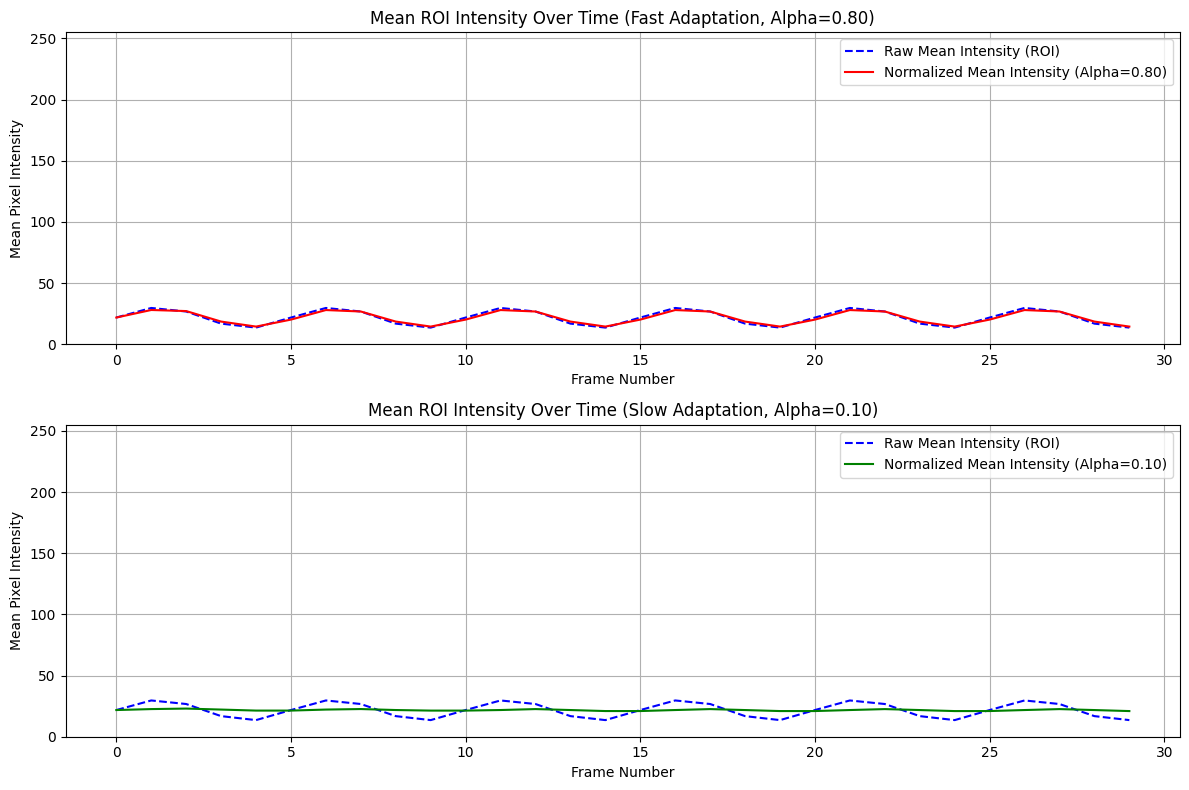


Standard Deviation of Mean ROI Intensities:
  Raw Frames:              5.97
  Normalized (Alpha=0.80): 5.10
  Normalized (Alpha=0.10): 0.61


In [5]:
plt.figure(figsize=(12, 8))

# Plot for Fast Adaptation (High Alpha)
plt.subplot(2, 1, 1)
plt.plot(raw_means_fast, label=f'Raw Mean Intensity (ROI)', color='blue', linestyle='--')
plt.plot(norm_means_fast, label=f'Normalized Mean Intensity (Alpha={ALPHA_FAST_ADAPT:.2f})', color='red')
# plt.plot(ref_means_fast, label=f'Reference Mean Intensity (Alpha={ALPHA_FAST_ADAPT:.2f})', color='green', linestyle=':')
plt.title(f'Mean ROI Intensity Over Time (Fast Adaptation, Alpha={ALPHA_FAST_ADAPT:.2f})')
plt.xlabel('Frame Number')
plt.ylabel('Mean Pixel Intensity')
plt.legend()
plt.grid(True)
plt.ylim(0, 255)

# Plot for Slow Adaptation (Low Alpha)
plt.subplot(2, 1, 2)
plt.plot(raw_means_slow, label=f'Raw Mean Intensity (ROI)', color='blue', linestyle='--') # Same raw data for comparison
plt.plot(norm_means_slow, label=f'Normalized Mean Intensity (Alpha={ALPHA_SLOW_ADAPT:.2f})', color='green')
# plt.plot(ref_means_slow, label=f'Reference Mean Intensity (Alpha={ALPHA_SLOW_ADAPT:.2f})', color='purple', linestyle=':')
plt.title(f'Mean ROI Intensity Over Time (Slow Adaptation, Alpha={ALPHA_SLOW_ADAPT:.2f})')
plt.xlabel('Frame Number')
plt.ylabel('Mean Pixel Intensity')
plt.legend()
plt.grid(True)
plt.ylim(0, 255)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR_NOTEBOOK, "mean_intensity_plots.png"))
plt.show()

# Calculate overall standard deviation of mean intensities
std_raw = np.std(raw_means_fast) # raw_means_fast and raw_means_slow are identical
std_norm_fast = np.std(norm_means_fast)
std_norm_slow = np.std(norm_means_slow)

print(f"\nStandard Deviation of Mean ROI Intensities:")
print(f"  Raw Frames:              {std_raw:.2f}")
print(f"  Normalized (Alpha={ALPHA_FAST_ADAPT:.2f}): {std_norm_fast:.2f}")
print(f"  Normalized (Alpha={ALPHA_SLOW_ADAPT:.2f}): {std_norm_slow:.2f}")

## 5. Observations and Conclusion

- **Effect of Alpha:**
    - A **high `alpha`** (e.g., 0.8) makes the normalized output track the raw input more closely. It adapts quickly to changes but provides less smoothing for rapid flickers. The mean intensity of normalized frames will still fluctuate significantly if the raw input does.
    - A **low `alpha`** (e.g., 0.1) makes the reference frame (and thus the normalized output) adapt much more slowly. This results in significant smoothing of the mean intensity, making it more stable despite fluctuations in the raw input. However, if there's a genuine, sustained change in overall scene brightness, a low alpha will take longer to adjust.

- **Trade-offs:**
    - **Responsiveness vs. Stability:** The choice of `alpha` is a trade-off. For smoothing out quick flickers from an AC light source or minor shadows, a lower alpha is better. For adapting to larger, slower changes in ambient light, a higher alpha might be preferred, or an adaptive alpha strategy.
    - **Initial Frame:** The first few normalized frames will be heavily influenced by the initial raw frames until the reference frame stabilizes.

- **Application to Project:**
    - For the conveyor belt project, if the enclosure provides generally stable lighting but is susceptible to minor, quick variations (e.g., reflections from different objects, slight power fluctuations affecting LEDs), a **moderately low alpha** (e.g., 0.1 to 0.3) for the `IlluminationNormalizer` could help provide more consistent input frames to the color and shape classifiers.
    - This technique primarily addresses **global or large-area illumination changes**. It won't fix localized shadows *within* an object if the object itself casts that shadow.

This temporal blending provides a simple and computationally inexpensive first step towards illumination normalization. More complex techniques (like a more sophisticated adaptive reference, or histogram-based methods applied temporally) could be considered if this proves insufficient.